# Group Details

## Group Name: Group 08

### Student 1: Jasper Linders

### Student 2: Alexander Liu

### Student 3: Sjoerd van Straten

# Loading Data and Preliminaries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [4]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""
example = load_array('data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [5]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Data Handling and Preprocessing

In [6]:
import os
from torch.utils.data import Dataset

class ImportData(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = sorted(os.listdir(folder_path))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        data, label = load_array(file_path, task='task 1')
        return data, label

# Create an instance of the custom dataset class with the folder path
train_import = ImportData('data/task 1/train/')
test_import = ImportData('data/task 1/test/')

X_train_import = []
y_train_import = []
X_test_import = []
y_test_import = []

# Iterate through the train_dataset to extract data and labels
for data, label in train_import:
    X_train_import.append(data)
    y_train_import.append(label)

for data, label in test_import:
    X_test_import.append(data)
    y_test_import.append(label)

max_length = 9

# Pad the data samples with zeros to have the same shape
X_train_padded = []
for data in X_train_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_train_padded.append(padded_data)

y_train_padded = []
for label in y_train_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_train_padded.append(padded_label)

X_test_padded = []
for data in X_test_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_test_padded.append(padded_data)

y_test_padded = []
for label in y_test_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_test_padded.append(padded_label)

# Convert the padded data and labels to tensors
X_train = torch.tensor(np.array(X_train_padded))
y_train = torch.tensor(np.array(y_train_padded))
X_test = torch.tensor(np.array(X_test_padded))
y_test = torch.tensor(np.array(y_test_padded))

# Print the shape of X_train and the first label in y_train
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([900, 9, 5])
torch.Size([900, 9, 2])
torch.Size([100, 9, 5])
torch.Size([100, 9, 2])


In [7]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# # Function to process a single data point
# def create_graph(data_point, label):

#     #Create node features
#     node_features = data_point  # Exclude the mass column

#     # Compute edge indices
#     edge_indices = []
#     for i in range(9):
#         for j in range(9):
#             if i != j:
#                 edge_indices.append([i, j])
#     edge_indices = torch.tensor(edge_indices).t().contiguous()

#     # Compute edge features
#     edge_features = []
#     for i in range(9):
#         for j in range(9):
#             if i != j:
#                 pos = node_features[j] - node_features[i]
#                 relative_position = torch.norm(pos)

#                 relative_mass = node_features[j, 0] / node_features[i, 0]
#                 if relative_mass == np.inf or relative_mass == 0:
#                     relative_position = 0
#                     relative_mass = 0

#                 edge_features.append([relative_position])     #, relative_mass])
#     edge_features = torch.FloatTensor(edge_features)

#     data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_features, y=label)

#     return data

$$ F_g = G*\frac{(m_1*m_2)}{r^2} $$

In [44]:
import torch
from torch_geometric.data import Data

# Function to process a single data point
def create_graph_Fg(data_points, labels):

    # Select the desired columns using the mask
    mask = np.ones(data_points.shape[1], dtype=bool)
    mask[[1,2]] = False
    #Create node features
    node_features = data_points[:, mask]
    # Create node positions
    node_positions = data_points[:,1:3]

    # print(node_features)
    # print(node_positions)

    edge_indices = []
    edge_features = []

    for i in range(9):
        for j in range(9):
            if i != j:
                # print(nodes[i])
                # print(nodes[j])
                pos = node_positions[j] - node_positions[i]
                r_sq = torch.square(torch.norm(pos))        # Euclidian Distance
                m_sq = node_features[i][0] * node_features[j][0]            # Masses multiplied
                F_g = m_sq / r_sq                           # Gravitational Force

                if F_g > 0.05:                               # Define when an edge can be created
                    edge_indices.append([i, j])
                    # edge_features.append([F_g])
                edge_features.append([r_sq])

    edge_indices = torch.tensor(edge_indices).t().contiguous()
    edge_features = torch.FloatTensor(edge_features)

    data = Data(x=node_features, pos=node_positions, edge_index=edge_indices, edge_attr=edge_features, y=labels)

    return data

In [45]:
ok = create_graph_Fg(X_train[100], y_train[100])
print(X_train[100])
ok.edge_index

tensor([[ 1.9319,  0.3562, -0.4139],
        [ 3.3920,  0.3606, -0.1661],
        [ 1.8558, -0.4109, -0.2760],
        [ 1.1297, -0.2625, -0.6228],
        [ 1.5087, -0.6786,  0.1561],
        [ 2.2685,  0.7406,  1.4900],
        [ 2.3237, -0.6492, -0.4461],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]], dtype=torch.float64)
tensor([[ 5.4860,  4.6715],
        [-2.7202,  6.6720],
        [ 2.9096, -3.8386],
        [ 6.7794, -0.0367],
        [-1.4004, -4.7095],
        [-3.0971,  5.3401],
        [ 5.4911, -3.4321],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], dtype=torch.float64)
tensor([[ 1.9319,  5.4860,  4.6715,  0.3562, -0.4139],
        [ 3.3920, -2.7202,  6.6720,  0.3606, -0.1661],
        [ 1.8558,  2.9096, -3.8386, -0.4109, -0.2760],
        [ 1.1297,  6.7794, -0.0367, -0.2625, -0.6228],
        [ 1.5087, -1.4004, -4.7095, -0.6786,  0.1561],
        [ 2.2685, -3.0971,  5.3401,  0.7406,  1.4900],
        [ 2.3237,  5.4911, -3.4321, -0.64

tensor([[0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 6, 6],
        [1, 3, 5, 6, 0, 5, 3, 4, 6, 0, 2, 6, 2, 6, 0, 1, 0, 2, 3, 4]])

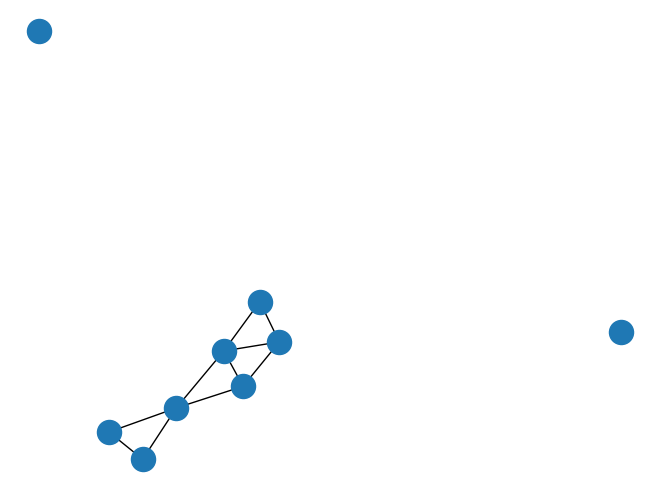

In [47]:
import networkx as nx
import torch_geometric

edge_index = ok.edge_index
edge_attr = ok.edge_attr
# print(edge_attr)
x = ok.x

data = ok
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [48]:
from torch_geometric.loader import DataLoader

# Load train data into a list of Data objects
train_graphs_lst = []
for i in range(len(X_train)):
    train_graphs_lst.append(create_graph_Fg(X_train[i], y_train[i]))

# Create train DataLoader
train_dataloader = DataLoader(train_graphs_lst, batch_size=1, shuffle=True)

# Load test data into a list of Data objects
test_graphs_lst = []
for i in range(len(X_test)):
    test_graphs_lst.append(create_graph_Fg(X_test[i], y_test[i]))

# Create test DataLoader
test_dataloader = DataLoader(test_graphs_lst, batch_size=1, shuffle=False)

tensor([[ 4.5467, -1.0969, -3.6693],
        [ 3.5751, -0.5787, -2.9597],
        [ 2.6773,  2.4265,  1.4587],
        [ 2.2746,  0.3042, -0.4066],
        [ 2.3836, -0.0764, -0.3595],
        [ 4.2860,  1.3563, -2.5576],
        [ 3.0312, -0.9477, 14.9813],
        [ 4.1353, -0.6990, -2.2509],
        [ 0.0000,  0.0000,  0.0000]], dtype=torch.float64)
tensor([[-5.2712,  5.0786],
        [ 4.3271, -0.0810],
        [-5.1597,  5.3524],
        [-6.7958,  2.2963],
        [-2.7586,  1.7794],
        [ 0.3498,  4.8286],
        [-0.5056, 15.0463],
        [ 1.8134,  3.8438],
        [ 0.0000,  0.0000]], dtype=torch.float64)
tensor([[ 2.6937, -1.1010, -2.2900],
        [ 1.8962, -1.2210,  0.6325],
        [ 2.7207, -1.1111, -0.1272],
        [ 2.8710, -0.7748,  0.7095],
        [ 4.7863,  2.1997,  0.6849],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]], dtype=torch.float64)
tensor([[ 2.0766

In [49]:
print('FIRST 3 BATCHES IN TRAIN LOADER:\n________________________________\n')

cnt = 0
for batch in train_dataloader:
    if cnt < 3:
        print(batch)
        print('Num graphs:', batch.num_graphs, '\n')
    cnt += 1
    batch1 = batch

print('.....')

FIRST 3 BATCHES IN TRAIN LOADER:
________________________________

DataBatch(x=[9, 3], edge_index=[2, 32], edge_attr=[72, 1], y=[9, 2], pos=[9, 2], batch=[9], ptr=[2])
Num graphs: 1 

DataBatch(x=[9, 3], edge_index=[2, 10], edge_attr=[72, 1], y=[9, 2], pos=[9, 2], batch=[9], ptr=[2])
Num graphs: 1 

DataBatch(x=[9, 3], edge_index=[2, 36], edge_attr=[72, 1], y=[9, 2], pos=[9, 2], batch=[9], ptr=[2])
Num graphs: 1 

.....


# Model Implementation

In [50]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, out_dim):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential()
        dims = [input_dim] + hid_dims + [out_dim]
        for i in range(len(dims)-1):
            self.mlp.add_module('layer_{}'.format(i),nn.Linear(in_features=dims[i], out_features=dims[i+1]))
            if i+2 < len(dims):
                self.mlp.add_module('activation_{}'.format(i), nn.ReLU())

    def reset_parameters(self):
        for i, l in enumerate(self.mlp):
            if type(l) == nn.Linear:
                nn.init.xavier_normal_(l.weight)

    def forward(self, x):
        return self.mlp(x)

In [51]:
from torch_geometric.nn.conv import GatedGraphConv

class GGNN(torch.nn.Module):
    def __init__(self):
        super(GGNN, self).__init__()
        
        self.conv = GatedGraphConv(out_channels=32, num_layers=5, aggr='sum')
        self.mlp = MLP(32, [32, 64, 128], 2)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, graph):
        x = self.conv(graph.x, graph.edge_index)
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [52]:
from collections import namedtuple

device = torch.device('cuda')

model = GGNN().double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

def train(train_graph):
    model.train()
    optimizer.zero_grad()
    train_pred = model(train_graph)
    train_loss = loss_fn(train_pred, train_graph.y)
    train_loss.backward()
    optimizer.step()
    return train_pred, train_loss

def test(test_graph):
    model.eval()
    test_pred = model(test_graph)
    test_loss = loss_fn(test_pred, test_graph.y)
    return test_pred, test_loss

In [61]:
GraphPred = namedtuple('GraphPred', ['graph', 'pred'])
train_graph_preds = []
test_graph_preds = []

for epoch in range(50):
    train_losses = 0
    test_losses = 0

    for batch in range(64):
        train_graph = next(iter(train_dataloader)).to(device)
        test_graph = next(iter(test_dataloader)).to(device)
        train_pred, train_loss = train(train_graph)
        test_pred, test_loss = test(test_graph)
        train_losses += train_loss
        test_losses += test_loss
        train_graph_preds.append(GraphPred(train_graph, train_pred))
        test_graph_preds.append(GraphPred(test_graph, test_pred))

    avg_train_loss = train_losses/64
    avg_test_loss = test_losses/64

    print(f'Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

Epoch: 0, Train Loss: 16.75440387469765, Test Loss: 21.766208396192713
Epoch: 1, Train Loss: 17.945491415450906, Test Loss: 21.777875820228115
Epoch: 2, Train Loss: 15.084828848127293, Test Loss: 21.24518997570224
Epoch: 3, Train Loss: 14.119700769256552, Test Loss: 21.174859916072418
Epoch: 4, Train Loss: 21.652360659779095, Test Loss: 21.876009406851892
Epoch: 5, Train Loss: 14.999592348232474, Test Loss: 21.18712927134693
Epoch: 6, Train Loss: 13.960736931623591, Test Loss: 21.472730731088742
Epoch: 7, Train Loss: 21.215305408551213, Test Loss: 21.322809790836125
Epoch: 8, Train Loss: 13.686441389165935, Test Loss: 20.52044715408448
Epoch: 9, Train Loss: 21.446230721871835, Test Loss: 21.32953449606862
Epoch: 10, Train Loss: 13.465203557101761, Test Loss: 19.69127286255872
Epoch: 11, Train Loss: 15.92067020872665, Test Loss: 19.561745876743995
Epoch: 12, Train Loss: 14.305185051659025, Test Loss: 19.25756532068351
Epoch: 13, Train Loss: 13.588239600659973, Test Loss: 19.837563949635

In [71]:
# write code to visualize the network layer weights here

print(model.conv.weight)
print(model.mlp.lin1.weight)

Parameter containing:
tensor([[[ 0.0486, -0.0574, -0.1691,  ...,  0.0697, -0.0517,  0.0083],
         [-0.0981, -0.1511,  0.0492,  ..., -0.1264, -0.1683, -0.2828],
         [ 0.3155, -0.3171, -0.1925,  ...,  0.2555, -0.2247,  0.0772],
         ...,
         [ 0.0322,  0.0513, -0.0089,  ..., -0.0984, -0.0909, -0.0406],
         [ 0.1714,  0.1059,  0.0676,  ..., -0.0830,  0.0283, -0.1479],
         [-0.0489,  0.0985,  0.0806,  ...,  0.1023,  0.0986,  0.1319]],

        [[-0.0119,  0.1201, -0.1540,  ..., -0.0507,  0.0140, -0.0192],
         [-0.0908, -0.1391, -0.0315,  ..., -0.1261,  0.0769, -0.0135],
         [ 0.3771, -0.1405, -0.1762,  ...,  0.3580, -0.1783,  0.1529],
         ...,
         [-0.0339, -0.0043, -0.0018,  ...,  0.0892, -0.0708,  0.0643],
         [ 0.0766,  0.1035, -0.0238,  ...,  0.1170,  0.1277, -0.0600],
         [ 0.0392, -0.1557, -0.1077,  ...,  0.1706, -0.0740,  0.0618]],

        [[ 0.0700,  0.1603, -0.2162,  ..., -0.0526, -0.0228, -0.0228],
         [-0.2012,  0.0

AttributeError: 'MLP' object has no attribute 'lin1'

In [63]:
train_ex = train_graph_preds[0]
ex_attr, ex_pos, ex_pred, ex_y = train_ex.graph.x.cpu().numpy(), train_ex.graph.pos.cpu().numpy(), train_ex.pred.cpu().detach().numpy(), train_ex.graph.y.cpu().numpy()
# mass = ex_x[:,0]
# x1,y1 = ex_x[:,1], ex_x[:,2]
# vx1,vy1 = ex_x[:,3], ex_x[:,4]
x2,y2 = ex_y[:,0], ex_y[:,1]
x2_pred,y2_pred = ex_pred[:,0], ex_pred[:,1]

In [67]:
# The arrays returned by the function are structures as follows:
# initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
# terminal_state: shape (n_bodies, [x, y])

particle_data = np.c_[ex_attr, ex_pos, x2, y2, x2_pred, y2_pred]

In [65]:
# Point Prediction Visualization Function (created with help of GPT)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_particles(particle_data):
    num_particles = particle_data.shape[0]

    # Prepare plot
    fig, ax = plt.subplots()

    # Plot particles
    for i in range(num_particles):
        mass = particle_data[i, 0]
        initial_x = particle_data[i, 3]
        initial_y = particle_data[i, 4]
        final_x = particle_data[i, 5]
        final_y = particle_data[i, 6]
        predicted_final_x = particle_data[i, 7]
        predicted_final_y = particle_data[i, 8]
        initial_vx = particle_data[i, 1]
        initial_vy = particle_data[i, 2]

        # Plot initial position with particle number
        ax.scatter(initial_x, initial_y, color=f'C{i}', s=mass*50, label=f'Particle {i+1}')
        ax.text(initial_x, initial_y, str(i+1), color='white', ha='center', va='center')

        # Plot final position with particle number and 'x'
        ax.scatter(final_x, final_y, color=f'C{i}', marker='x')
        ax.text(final_x, final_y, f'{i+1}', color='grey', ha='center', va='bottom')

        # Plot predicted final position with 'x'
        ax.scatter(predicted_final_x, predicted_final_y, color=f'C{i}', marker='x', alpha=0.3)

        # Plot line connecting real and predicted final positions
        ax.plot([final_x, predicted_final_x], [final_y, predicted_final_y], color=f'C{i}', linestyle='dotted', alpha=0.5)

        # # Calculate position for particle number text
        # text_x = (final_x + predicted_final_x) / 2
        # text_y = (final_y + predicted_final_y) / 2 + 0.2

        # # # Annotate particle number above the line
        # # ax.annotate(f'{i+1}', (text_x, text_y), color=f'C{i}', ha='center', va='bottom')

        # Plot velocity vector
        ax.arrow(initial_x, initial_y, initial_vx, initial_vy, color=f'C{i}', head_width=0.2)

    # Set labels and title
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.set_title('Point Prediction Visualization')

    # Create custom legend handles and labels
    legend_elements = [
        Line2D([0], [0], marker='x', linestyle='None', color='k', label='Final Position'),
        Line2D([0], [0], marker='x', linestyle='None', color='k', alpha=0.3, label='Predicted Final Position'),
        Line2D([0], [0], marker='>', linestyle='None', color='k', label='Velocity Vector'),
        Line2D([0], [0], marker='o', linestyle='None', color='k', label='Particle Number (Size ~ Mass)'),
        Line2D([0], [0], color='k', linestyle='dotted', label='Difference Between Real and Pred')
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), loc='upper left')

    # Show the plot
    plt.show()

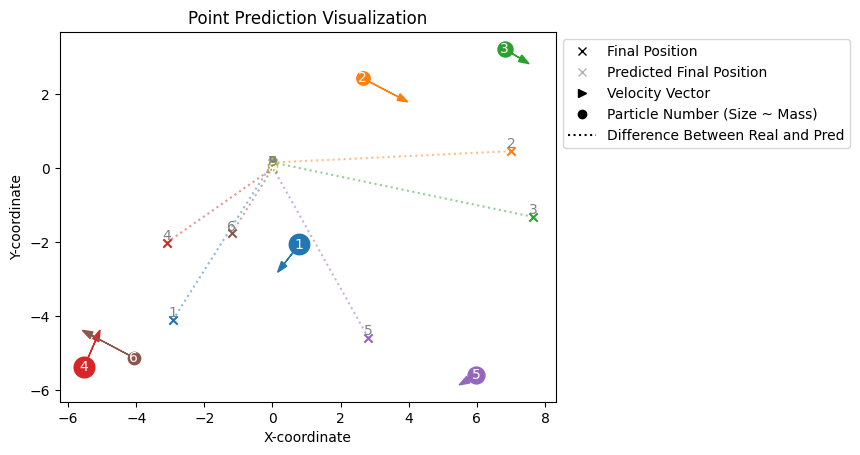

In [66]:
visualize_particles(particle_data)